<img src="https://cdn.comet.ml/img/notebook_logo.png">

# Introduction

[Artifacts](https://www.comet.com/site/products/artifacts-dataset-management/?utm_campaign-artifacts-launch&utm_source=colab-example&utm_medium=frontmatter) is a new tool that provides Machine Learning Teams with a convenient way to log, version, and access data from all parts of the experimentation pipeline. 


## What are Artifacts?

We’ve built Comet Artifacts to help Machine Learning teams solve the challenges of iterating on datasets and tracking pipelines where the data generated from one experiment is fed into another experiment.

An Artifact is composed of Artifact versions. Each Artifact has a name, a type, description, tags, and metadata.

An Artifact version is a snapshot of files and assets, arranged in a folder-like logical structure. This snapshot can be tracked using metadata, a version number, tags, and aliases. A version tracks which experiments consumed it, and which experiment produced it.

For a more complete overview [check out our full annoucement here](https://www.comet.com/site/blog/announcing-comet-artifacts/?utm_campaign-artifacts-launch&utm_source=colab-example&utm_medium=additional-resources)


# Setup

Install Comet and initialize a Project to try out Artifacts 

In [ ]:
%pip install -U "comet_ml>=3.44.0" pandas scikit-learn joblib

In [ ]:
import comet_ml

comet_ml.login(project_name="guide-artifacts-demo")

# Getting the Data

For this example, we will use the California Housing Prices Dataset. Lets load the data and create a training and test set.  

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_california_housing as load_data
from sklearn.model_selection import train_test_split

dataset = load_data()
X, y = dataset.data, dataset.target
featurecols = dataset.feature_names

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

train_df = pd.DataFrame(X_train, columns=featurecols)
test_df = pd.DataFrame(X_test, columns=featurecols)

train_df["target"] = y_train
test_df["target"] = y_test

In [ ]:
train_df.head()

In [ ]:
import os

os.makedirs("./datasets", exist_ok=True)

train_df.to_csv("./datasets/train.csv", index=False)
test_df.to_csv("./datasets/test.csv", index=False)

# Creating an Artifact to track the Dataset

Let's track our dataset with an Artifact. In order to create an Artifact, you will have to provide a name for it. You also have the option of providing additional information about the Artifact. You can provide a type string that identifies what kind of Artifact you are uploading (a model, dataset, etc). 

You can add alias identifiers to the Artifact, such as "test data" or "staging model". Later in this tutorial we will show you how Artifacts can be retrieved based on these aliases. 

Finally, you can attach a metadata dictionary to both the individual data assets uploaded to an Artifact as well as the Artifact itself. You can add any additional information about your Artifact in this dictionary.  



In [ ]:
# Create a Comet Artifact
artifact = comet_ml.Artifact(
    name="california",
    artifact_type="dataset",
    aliases=["raw"],
    metadata={"task": "regression"},
)

# Add files to the Artifact
for split, asset in zip(
    ["train", "test"], ["./datasets/train.csv", "./datasets/test.csv"]
):
    artifact.add(asset, metadata={"dataset_stage": "raw", "dataset_split": split})

experiment = comet_ml.Experiment()
experiment.add_tag("upload")
experiment.log_artifact(artifact)

experiment.end()

In your Workspace, you will see an Artifacts tab where you can view the data that has been uploaded. 

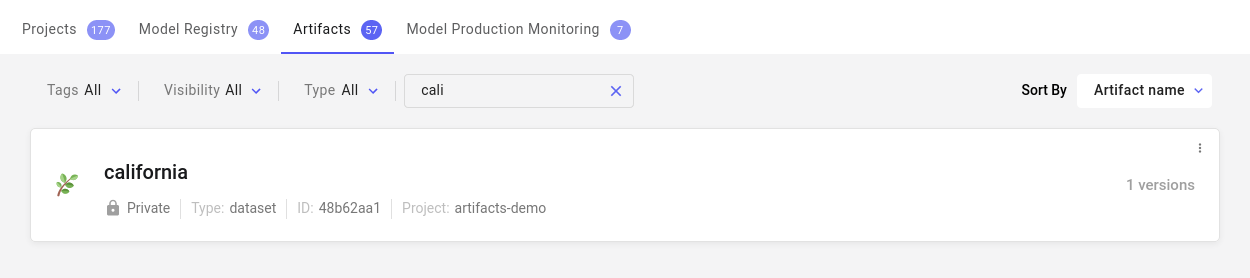

Clicking on the Artifact will bring up the Version information and associated Metadata. 

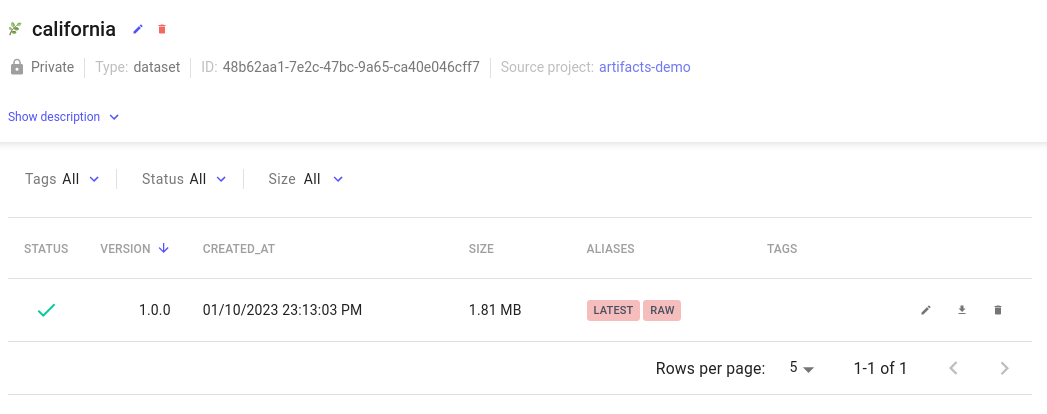

# Using an Artifact

Now that we have an Artifact tracking our dataset, let's move on to using it to train a model!  


First, let's make a directory to save our Artifacts.

In [ ]:
! mkdir ./artifacts

### Download the Artifact

We can fetch the Artifact we need using its name, and either the version or alias.  

In [ ]:
experiment = comet_ml.Experiment()
experiment.add_tag("train")

# Fetch the Artifact object from Comet
name = "california"
version_or_alias = "raw"
artifact = experiment.get_artifact(name, version_or_alias=version_or_alias)

# Download Artifact
output_path = "./artifacts"
artifact.download(output_path, overwrite_strategy="PRESERVE")

### Train a Model

In [ ]:
from sklearn.linear_model import LinearRegression
from joblib import dump

# Load Data from Artifact
train_df = pd.read_csv("./artifacts/train.csv")
test_df = pd.read_csv("./artifacts/test.csv")

y_train = train_df.pop("target").values
X_train = train_df.values

y_test = test_df.pop("target").values
X_test = test_df.values

# Initialize Model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate Model
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

experiment.log_metric("train-score", train_score)
experiment.log_metric("test-score", test_score)

# Save Model
model_path = "./linear-model.pkl"
dump(model, model_path)

# Log Model as an Artifact

Let's log the model we just trained as an Artifact. 

In [ ]:
# Log Model as an Artifact
model_artifact = comet_ml.Artifact(
    "housing-model", artifact_type="model", aliases=["baseline"]
)
model_artifact.add(model_path)
experiment.log_artifact(model_artifact)

You can view the Artifacts Produced and Consumed by an Experiment in the "Assets and Artifacts" tab under Artifacts. Toggle the direction selector to filter by Input, which refers to Artifacts that were consumed, and Output which refers to Artifacts that were produced  

In [ ]:
experiment.display(tab="assets")
experiment.end()

# Updating an Artifact 

Our scores on the raw dataset were not that great. Why don't we scale the data and update our Artifact to reflect this.  

In [ ]:
# Scores aren't great, so lets scale the features
from sklearn.preprocessing import StandardScaler as Scaler

experiment = comet_ml.Experiment()
experiment.add_tag("upload")

X_scaler = Scaler().fit(X_train)
y_scaler = Scaler().fit(y_train.reshape(-1, 1))

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.transform(y_train.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

train_scaled_df = pd.DataFrame(X_train, columns=featurecols)
test_scaled_df = pd.DataFrame(X_test, columns=featurecols)

train_scaled_df["target"] = y_train
test_scaled_df["target"] = y_test

train_scaled_df.to_csv("./datasets/train-scaled.csv")
test_scaled_df.to_csv("./datasets/test-scaled.csv")

# Update Artifact with Scaled Data
scaled_dataset_artifact = comet_ml.Artifact(
    "california",
    artifact_type="dataset",
    aliases=["standard-scaled"],
    metadata={"task": "regression"},
)
# Add files to the Artifact
for split, asset in zip(
    ["train", "test"], ["./datasets/train-scaled.csv", "./datasets/test-scaled.csv"]
):
    scaled_dataset_artifact.add(
        asset, metadata={"dataset_stage": "standard-scaled", "dataset_split": split}
    )

experiment.log_artifact(scaled_dataset_artifact)
experiment.end()

# Train a Model with the Latest Version of the Dataset Artifact

In [ ]:
experiment = comet_ml.Experiment()
experiment.add_tag("train")

# Fetch the Artifact object from Comet
name = "california"
version_or_alias = "standard-scaled"
artifact = experiment.get_artifact(name, version_or_alias=version_or_alias)


# Download Artifact
output_path = "./artifacts"
artifact.download(output_path, overwrite_strategy="PRESERVE")

# Load Data from Artifact
train_df = pd.read_csv("./artifacts/train-scaled.csv")
test_df = pd.read_csv("./artifacts/test-scaled.csv")

y_train = train_df.pop("target").values
X_train = train_df.values

y_test = test_df.pop("target").values
X_test = test_df.values

# Initialize Model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate Model
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

experiment.log_metric("train-score", train_score)
experiment.log_metric("test-score", test_score)

In [ ]:
experiment.end()

Doesn't look like the scaling helped :( Back to the drawing board!

# Conclusion

We hope you enjoyed this introductory guide to Artifacts, a simple, light weight way to version your datasets and models, while providing information about the lineage of your data through your experiments. 

Interested in learning more about Artifacts? Check out the [docs](https://www.comet.ml/docs/user-interface/artifacts/?utm_campaign-artifacts-launch&utm_source=colab-example&utm_medium=additional-resources)